In [343]:
import numpy as np
import pandas as pd
import datamol as dm
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw, rdFingerprintGenerator, MACCSkeys, PandasTools, DataStructs, Descriptors
from rdkit.ML.Cluster import Butina
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
from chembl_webresource_client.new_client import new_client
from pathlib import Path

In [344]:
pd.options.display.max_columns = 50

Currrent working directory

In [345]:
cwd = Path.cwd()

Looking for ChEMBL251 data (it's uniprot id is P29274)

In [346]:
uniprot_id = 'P29274'

Setting client components

In [347]:
target_api = new_client.target
bioactivity_api = new_client.activity
molecules_api = new_client.molecule

In [348]:
targets = target_api.get(
    target_components__accession=uniprot_id
)

In [349]:
targets

[{'cross_references': [{'xref_id': 'P29274', 'xref_name': None, 'xref_src': 'canSAR-Target'}, {'xref_id': 'Adenosine_A2A_receptor', 'xref_name': None, 'xref_src': 'Wikipedia'}, {'xref_id': 'NBK22976', 'xref_name': 'Adenosine A2A receptor', 'xref_src': 'MICAD'}, {'xref_id': 'NBK23199', 'xref_name': 'Adenosine A2A receptor', 'xref_src': 'MICAD'}], 'organism': 'Homo sapiens', 'pref_name': 'Adenosine A2a receptor', 'species_group_flag': False, 'target_chembl_id': 'CHEMBL251', 'target_components': [{'accession': 'P29274', 'component_description': 'Adenosine receptor A2a', 'component_id': 326, 'component_type': 'PROTEIN', 'relationship': 'SINGLE PROTEIN', 'target_component_synonyms': [{'component_synonym': 'Adenosine receptor A2a', 'syn_type': 'UNIPROT'}, {'component_synonym': 'ADORA2', 'syn_type': 'GENE_SYMBOL_OTHER'}, {'component_synonym': 'ADORA2A', 'syn_type': 'GENE_SYMBOL'}], 'target_component_xrefs': [{'xref_id': 'P29274', 'xref_name': None, 'xref_src_db': 'ExpressionAtlas'}, {'xref_id

We have found 7 targets

In [350]:
len(targets)

7

In [351]:
targets_df = pd.DataFrame(targets)

In [352]:
targets_df

,cross_references,organism,pref_name,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P29274', 'xref_name': None, 'xre...",Homo sapiens,Adenosine A2a receptor,False,CHEMBL251,"[{'accession': 'P29274', 'component_descriptio...",SINGLE PROTEIN,9606
1,[],Homo sapiens,Adenosine A2 receptor,False,CHEMBL2094257,"[{'accession': 'P29275', 'component_descriptio...",PROTEIN FAMILY,9606
2,[],Homo sapiens,Adenosine receptors; A2a & A3,False,CHEMBL2095213,"[{'accession': 'P0DMS8', 'component_descriptio...",SELECTIVITY GROUP,9606
3,[],Homo sapiens,Adenosine receptors; A1 & A2,False,CHEMBL2096679,"[{'accession': 'P30542', 'component_descriptio...",SELECTIVITY GROUP,9606
4,[],Homo sapiens,Adenosine receptors; A1 & A2a,False,CHEMBL2096982,"[{'accession': 'P30542', 'component_descriptio...",SELECTIVITY GROUP,9606
5,[],Homo sapiens,Adenosine receptor,False,CHEMBL2111329,"[{'accession': 'P30542', 'component_descriptio...",PROTEIN FAMILY,9606
6,[],Homo sapiens,Adenosine receptors; A2a & A2b,False,CHEMBL4296621,"[{'accession': 'P29275', 'component_descriptio...",SELECTIVITY GROUP,9606


We will use target_chembl_id of the first record as target

In [353]:
target = targets_df['target_chembl_id'][0]
target

'CHEMBL251'

We will search for bioactivities related with CHEMBL251 as target

Let's see all columns

In [354]:
all_columns = bioactivity_api.filter(
    target_chembl_id=target
)

In [355]:
pd.Series(all_columns[0])

action_type                                                               None
activity_comment                                                          None
activity_id                                                              32555
activity_properties                                                         []
assay_chembl_id                                                   CHEMBL644471
assay_description            Antagonist activity against recombinant human ...
assay_type                                                                   F
assay_variant_accession                                                   None
assay_variant_mutation                                                    None
bao_endpoint                                                       BAO_0000192
bao_format                                                         BAO_0000219
bao_label                                                    cell-based format
canonical_smiles             CCCn1c(=O)c2nc(-c3ccc(O

I will use this columns

In [356]:
columns_of_interest = ['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type', 'molecule_chembl_id', 'pchembl_value', 'type', 'standard_units', 'relation', 'standard_value', 'target_chembl_id', 'target_organism']
len(columns_of_interest)

12

Let's download acitivities (or load them, if the file exists)

In [357]:
file_bio = cwd / 'bioactivities.csv'
if file_bio.exists():
    bioactivities_df = pd.read_csv(file_bio, index_col=0)
else:
    bioactivities = bioactivity_api.filter(
        target_chembl_id=target, assay_type='B', type='Ki', relation__in=['<', '<=', '=']
    ).only(
        columns_of_interest
    )
    bioactivities_df = pd.DataFrame(bioactivities)
    bioactivities_df.to_csv(file_bio)
bioactivities_df.shape

(5022, 14)

Let's axamine data

In [358]:
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,pchembl_value,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,38792,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL132806,7.24,=,nM,57.0,CHEMBL251,Homo sapiens,Ki,nM,57.0
1,39908,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL336217,7.38,=,nM,42.0,CHEMBL251,Homo sapiens,Ki,nM,42.0
2,41114,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL134566,7.22,=,nM,60.0,CHEMBL251,Homo sapiens,Ki,nM,60.0
3,41122,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL435022,7.42,=,nM,38.0,CHEMBL251,Homo sapiens,Ki,nM,38.0
4,41130,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL341376,6.37,=,nM,423.0,CHEMBL251,Homo sapiens,Ki,nM,423.0


In [359]:
bioactivities_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5022 entries, 0 to 5021
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   activity_id         5022 non-null   int64  
 1   assay_chembl_id     5022 non-null   object 
 2   assay_description   5022 non-null   object 
 3   assay_type          5022 non-null   object 
 4   molecule_chembl_id  5022 non-null   object 
 5   pchembl_value       4999 non-null   float64
 6   relation            5022 non-null   object 
 7   standard_units      5022 non-null   object 
 8   standard_value      5022 non-null   float64
 9   target_chembl_id    5022 non-null   object 
 10  target_organism     5022 non-null   object 
 11  type                5022 non-null   object 
 12  units               5022 non-null   object 
 13  value               5022 non-null   float64
dtypes: float64(3), int64(1), object(10)
memory usage: 588.5+ KB


We can see that pchembl_valu and standard_value are object, not float

In [360]:
bioactivities_df['pchembl_value'] = bioactivities_df['pchembl_value'].astype('float')
bioactivities_df['standard_value'] = bioactivities_df['standard_value'].astype('float')

In [361]:
bioactivities_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5022 entries, 0 to 5021
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   activity_id         5022 non-null   int64  
 1   assay_chembl_id     5022 non-null   object 
 2   assay_description   5022 non-null   object 
 3   assay_type          5022 non-null   object 
 4   molecule_chembl_id  5022 non-null   object 
 5   pchembl_value       4999 non-null   float64
 6   relation            5022 non-null   object 
 7   standard_units      5022 non-null   object 
 8   standard_value      5022 non-null   float64
 9   target_chembl_id    5022 non-null   object 
 10  target_organism     5022 non-null   object 
 11  type                5022 non-null   object 
 12  units               5022 non-null   object 
 13  value               5022 non-null   float64
dtypes: float64(3), int64(1), object(10)
memory usage: 588.5+ KB


What units are used?

In [362]:
bioactivities_df['units'].unique()

array(['nM', 'uM', "10'-8M", "10'3nM", 'fM', 'pM'], dtype=object)

We can drop units and values columns because of various units used. We will standard columns instead

In [363]:
bioactivities_df.drop(columns=['units', 'value'], inplace=True)
bioactivities_df.shape

(5022, 12)

Lets drop nan (we currently don't any, but there may be some in the future) and duplicates

In [364]:
bioactivities_df.dropna(axis='index',how='any', inplace=True)
bioactivities_df.drop_duplicates(subset='molecule_chembl_id', keep='first', inplace=True)
bioactivities_df.shape

(4177, 12)

All units are in nM

In [365]:
bioactivities_df['standard_units'].unique()

array(['nM'], dtype=object)

Let's examine columns' names

In [366]:
bioactivities_df.columns

Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'pchembl_value', 'relation', 'standard_units',
       'standard_value', 'target_chembl_id', 'target_organism', 'type'],
      dtype='object')

Which column to use: to calculate pKi or to use pchembl_value column?

In [367]:
bioactivities_df['pKi'] = bioactivities_df['standard_value'].apply(lambda x: -np.log10(x * 1e-09))

Let's drop pKi column and rename pchembl_value column to pKi, standard_units to units and standard_value to Ki

In [368]:
bioactivities_df.drop(columns='pKi', inplace=True)

In [369]:
bioactivities_df.rename(columns={'pchembl_value': 'pKi', 'standard_units': 'units', 'standard_value': 'Ki'}, inplace=True)

In [370]:
bioactivities_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4177 entries, 0 to 5020
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   activity_id         4177 non-null   int64  
 1   assay_chembl_id     4177 non-null   object 
 2   assay_description   4177 non-null   object 
 3   assay_type          4177 non-null   object 
 4   molecule_chembl_id  4177 non-null   object 
 5   pKi                 4177 non-null   float64
 6   relation            4177 non-null   object 
 7   units               4177 non-null   object 
 8   Ki                  4177 non-null   float64
 9   target_chembl_id    4177 non-null   object 
 10  target_organism     4177 non-null   object 
 11  type                4177 non-null   object 
dtypes: float64(2), int64(1), object(9)
memory usage: 424.2+ KB


Let's reset index

In [371]:
bioactivities_df.reset_index(drop=True, inplace=True)

Check bioactivities_df and it's shape and save it

In [372]:
bioactivities_df.head(3)

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,pKi,relation,units,Ki,target_chembl_id,target_organism,type
0,38792,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL132806,7.24,=,nM,57.0,CHEMBL251,Homo sapiens,Ki
1,39908,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL336217,7.38,=,nM,42.0,CHEMBL251,Homo sapiens,Ki
2,41114,CHEMBL643209,Displacement of [3H]ZM-241385 from human adeno...,B,CHEMBL134566,7.22,=,nM,60.0,CHEMBL251,Homo sapiens,Ki


In [373]:
bioactivities_df.shape

(4177, 12)

In [374]:
bioactivities_df.to_csv('bioactivities_cleaned.csv')

The next task to download smiles for those molecules

In [375]:
molecules = molecules_api.filter(
    molecule_chembl_id__in=bioactivities_df['molecule_chembl_id'].to_list()
).only(
    'molecule_chembl_id', 'molecule_structures'
)

Lets check things with first molecule

In [376]:
molecules[0]

{'molecule_chembl_id': 'CHEMBL10',
 'molecule_structures': {'canonical_smiles': 'C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)cc1',
  'molfile': '\n     RDKit          2D\n\n 27 30  0  0  0  0  0  0  0  0999 V2000\n   10.3778   -8.9759    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    9.7898   -8.6390    0.0000 S   0  0  0  0  0  0  0  0  0  0  0  0\n    9.7877   -7.9612    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0\n    9.0572   -9.0655    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    9.0585   -9.9128    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    8.3255  -10.3375    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    7.5911   -9.9151    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    7.5898   -9.0679    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    8.3228   -8.6431    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    6.8577  -10.3401    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    6.7798  -11.1765    0.0000 N   0  0  0  0  0  0  0  0  0  0  0

It looks that everything is alright, so we can download data for all molecules

In [377]:
molecules_df = pd.DataFrame(molecules)

Lets examine molecules_df

In [378]:
molecules_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   molecule_chembl_id   4177 non-null   object
 1   molecule_structures  4177 non-null   object
dtypes: object(2)
memory usage: 65.4+ KB


In [379]:
molecules_df.shape

(4177, 2)

I think that the best thing is to drop nan's before everything else

In [380]:
molecules_df.dropna(axis='index', how='any', inplace=True)
molecules_df.shape

(4177, 2)

Lets extract smiles form molecule_structures to separate column

In [381]:
smiles_list = []
for _, row in molecules_df.iterrows():
    try:
        smiles_list.append(row['molecule_structures']['canonical_smiles'])
    except KeyError:
        # if there is no smiles for this molecule
        smiles_list.append(None)
molecules_df['smiles'] = smiles_list

In [382]:
molecules_df.head(3)

,molecule_chembl_id,molecule_structures,smiles
0,CHEMBL10,{'canonical_smiles': 'C[S+]([O-])c1ccc(-c2nc(-...,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...
1,CHEMBL411,{'canonical_smiles': 'CC/C(=C(/CC)c1ccc(O)cc1)...,CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1
2,CHEMBL7098,{'canonical_smiles': 'Cn1c2ccccc2n2c(=O)c(-c3c...,Cn1c2ccccc2n2c(=O)c(-c3ccco3)nnc12


Lets drop molecule_structures column and drop nan if there are any

In [383]:
molecules_df.drop(columns=['molecule_structures'], inplace=True)

In [384]:
molecules_df.dropna(axis='index', how='any', inplace=True)
molecules_df.shape

(4177, 2)

It looks that two molecules has the same smiles

In [385]:
molecules_df[molecules_df['smiles'].duplicated(False)]

,molecule_chembl_id,smiles
599,CHEMBL331291,CNC(=O)[C@]12C[C@@H]1[C@@H](n1cnc3c(NC4CCCC4)n...
1797,CHEMBL573937,CNC(=O)[C@]12C[C@@H]1[C@@H](n1cnc3c(NC4CCCC4)n...


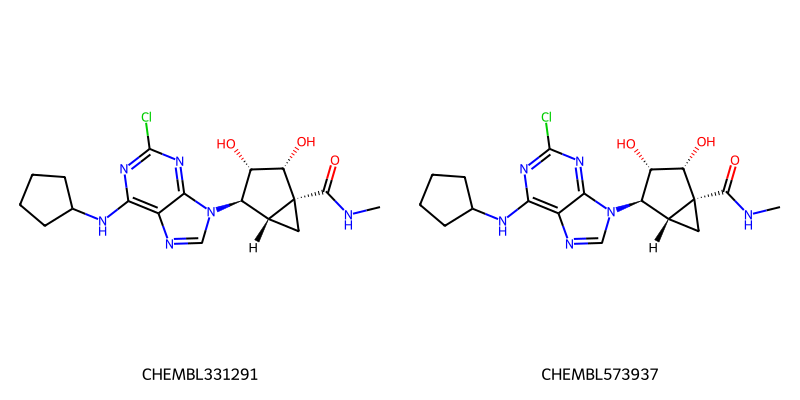

In [386]:
Draw.MolsToGridImage(
    molecules_df['smiles'][molecules_df['smiles'].duplicated(False)].apply(Chem.MolFromSmiles),
    legends=molecules_df['molecule_chembl_id'][molecules_df['smiles'].duplicated(False)].to_list(),
    molsPerRow=2,
    subImgSize=(400, 400)
)

Lets examine this situation a litle

In [387]:
duplicates = molecules_api.filter(
    molecule_chembl_id__in=molecules_df['molecule_chembl_id'][molecules_df['smiles'].duplicated(False)].to_list()
).only(
    'molecule_chembl_id', 'molecule_structures'
)

In [388]:
duplicates = pd.DataFrame(duplicates)
duplicates

,molecule_chembl_id,molecule_structures
0,CHEMBL331291,{'canonical_smiles': 'CNC(=O)[C@]12C[C@@H]1[C@...
1,CHEMBL573937,{'canonical_smiles': 'CNC(=O)[C@]12C[C@@H]1[C@...


In [389]:
duplicates['molecule_structures'][0]

{'canonical_smiles': 'CNC(=O)[C@]12C[C@@H]1[C@@H](n1cnc3c(NC4CCCC4)nc(Cl)nc31)[C@H](O)[C@@H]2O',
 'molfile': '\n     RDKit          2D\n\n 28 32  0  0  1  0  0  0  0  0999 V2000\n   12.3670    1.7051    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0\n   11.6551    1.2834    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   11.6654    0.4580    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0\n   13.0855    1.3040    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   13.0992    0.4800    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   12.3873    0.0513    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   12.5750   -0.7583    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0\n   13.4030   -0.8300    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   13.7269   -0.0647    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0\n   13.7935    1.7275    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0\n   12.1688   -1.4754    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   11.5032   -0.9857    0.0000 C   0  0 

In [390]:
duplicates['molecule_structures'][1]

{'canonical_smiles': 'CNC(=O)[C@]12C[C@@H]1[C@@H](n1cnc3c(NC4CCCC4)nc(Cl)nc31)[C@H](O)[C@@H]2O',
 'molfile': '\n     RDKit          2D\n\n 29 33  0  0  0  0  0  0  0  0999 V2000\n   -0.7232  -10.5307    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.0104  -10.1183    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.0104   -9.2931    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0\n   -0.7232   -8.8764    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.4360  -10.1183    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.4359   -9.2904    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.2233   -9.0323    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.7140   -9.7042    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.2234  -10.3761    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.4835  -11.1610    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -2.4832  -12.4978    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -1.9968  -11.8313    0.0000 C   0  0 

In [391]:
mol_0 = Chem.MolFromMolBlock(duplicates['molecule_structures'][0]['molfile'])
naziv_0 = duplicates['molecule_chembl_id'][0]
mol_1 = Chem.MolFromMolBlock(duplicates['molecule_structures'][1]['molfile'])
naziv_1 =duplicates['molecule_chembl_id'][1]

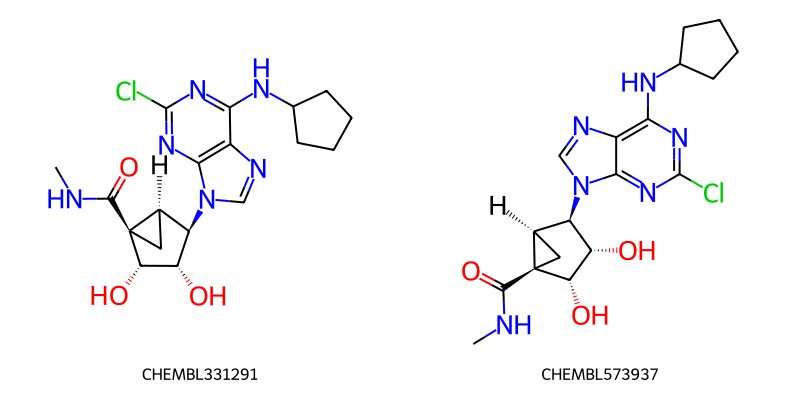

In [392]:
Draw.MolsToGridImage(
    [mol_0, mol_1],
    legends=[naziv_0, naziv_1],
    molsPerRow=2,
    subImgSize=(400, 400)
)

It looks like these are right structures 

https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL573937/

https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL331291/

Now we can make smiles from these mols to check if they are the same again

In [393]:
smiles_0 = Chem.MolToSmiles(mol_0)
smiles_1 = Chem.MolToSmiles(mol_1)
smiles_0, smiles_1, smiles_0 == smiles_1

('CNC(=O)[C@]12C[C@@H]1[C@@H](n1cnc3c(NC4CCCC4)nc(Cl)nc31)[C@H](O)[C@@H]2O',
 'CNC(=O)[C@]12C[C@@H]1[C@@H](n1cnc3c(NC4CCCC4)nc(Cl)nc31)[C@H](O)[C@@H]2O',
 True)

Smiles are the same again.

Its seems that everything is OK, even ChEMBL site says that these molecules are 100% similar,
so I will keep them both for now.

There are no duplicates in molecule_chembl_id column

In [394]:
molecules_df[molecules_df['molecule_chembl_id'].duplicated() == True]

,molecule_chembl_id,smiles


Lets merge bioactivities_df and molecules_df. From bioactivities_df we will use columns:

'molecule_chembl_id', 'Ki', 'units', pKi

In [395]:
bioactivities_df.columns

Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'pKi', 'relation', 'units', 'Ki',
       'target_chembl_id', 'target_organism', 'type'],
      dtype='object')

In [396]:
data_1 = pd.merge(
    left=bioactivities_df[['molecule_chembl_id', 'Ki', 'units', 'pKi']],
    right=molecules_df,
    on='molecule_chembl_id'
    )

In [397]:
data_1.reset_index(drop=True, inplace=True)

Let's check if everything is OK and save data frame

In [398]:
data_1.head()

,molecule_chembl_id,Ki,units,pKi,smiles
0,CHEMBL132806,57.0,nM,7.24,CC(C)CCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4...
1,CHEMBL336217,42.0,nM,7.38,CC(C)CCn1cc2c(nc(NC(=O)Cc3cccc4ccccc34)n3nc(-c...
2,CHEMBL134566,60.0,nM,7.22,O=C(Cc1ccccc1)Nc1nc2nn(CCCc3ccccc3)cc2c2nc(-c3...
3,CHEMBL435022,38.0,nM,7.42,CC(C)CCn1cc2c(nc(NC(=O)COc3ccccc3)n3nc(-c4ccco...
4,CHEMBL341376,423.0,nM,6.37,Cn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4)nc23)n1


In [399]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  4177 non-null   object 
 1   Ki                  4177 non-null   float64
 2   units               4177 non-null   object 
 3   pKi                 4177 non-null   float64
 4   smiles              4177 non-null   object 
dtypes: float64(2), object(3)
memory usage: 163.3+ KB


In [400]:
data_1.to_csv('data.csv')

Let's again take a look on duplicate smiles

In [401]:
data_1[data_1.duplicated(subset='smiles', keep=False)]

,molecule_chembl_id,Ki,units,pKi,smiles
627,CHEMBL573937,3250.0,nM,5.49,CNC(=O)[C@]12C[C@@H]1[C@@H](n1cnc3c(NC4CCCC4)n...
3707,CHEMBL331291,3250.0,nM,5.49,CNC(=O)[C@]12C[C@@H]1[C@@H](n1cnc3c(NC4CCCC4)n...


In [402]:
ids = data_1['molecule_chembl_id'][data_1['smiles'].duplicated(keep=False)]
ids

627     CHEMBL573937
3707    CHEMBL331291
Name: molecule_chembl_id, dtype: object

Let's check one more thing

In [403]:
dupli = molecules_api.filter(
    molecule_chembl_id__in=ids.to_list()
)

In [404]:
dupli

[{'atc_classifications': [], 'availability_type': -1, 'biotherapeutic': None, 'black_box_warning': 0, 'chebi_par_id': None, 'chemical_probe': 0, 'chirality': -1, 'cross_references': [], 'dosed_ingredient': False, 'first_approval': None, 'first_in_class': -1, 'helm_notation': None, 'indication_class': None, 'inorganic_flag': -1, 'max_phase': None, 'molecule_chembl_id': 'CHEMBL331291', 'molecule_hierarchy': {'active_chembl_id': 'CHEMBL331291', 'molecule_chembl_id': 'CHEMBL331291', 'parent_chembl_id': 'CHEMBL331291'}, 'molecule_properties': {'alogp': '0.86', 'aromatic_rings': 2, 'cx_logd': '0.27', 'cx_logp': '0.27', 'cx_most_apka': '13.12', 'cx_most_bpka': '2.18', 'full_molformula': 'C18H23ClN6O3', 'full_mwt': '406.87', 'hba': 8, 'hba_lipinski': 9, 'hbd': 4, 'hbd_lipinski': 4, 'heavy_atoms': 28, 'molecular_species': 'NEUTRAL', 'mw_freebase': '406.87', 'mw_monoisotopic': '406.1520', 'np_likeness_score': '-0.01', 'num_lipinski_ro5_violations': 0, 'num_ro5_violations': 0, 'psa': '125.19', 'q

In [405]:
dupli_df = pd.DataFrame(dupli)
dupli_df

,atc_classifications,availability_type,biotherapeutic,black_box_warning,chebi_par_id,chemical_probe,chirality,cross_references,dosed_ingredient,first_approval,first_in_class,helm_notation,indication_class,inorganic_flag,max_phase,molecule_chembl_id,molecule_hierarchy,molecule_properties,molecule_structures,molecule_synonyms,molecule_type,natural_product,oral,orphan,parenteral,polymer_flag,pref_name,prodrug,structure_type,therapeutic_flag,topical,usan_stem,usan_stem_definition,usan_substem,usan_year,withdrawn_flag
0,[],-1,None,0,None,0,-1,[],False,None,-1,None,None,-1,None,CHEMBL331291,"{'active_chembl_id': 'CHEMBL331291', 'molecule...","{'alogp': '0.86', 'aromatic_rings': 2, 'cx_log...",{'canonical_smiles': 'CNC(=O)[C@]12C[C@@H]1[C@...,[],Small molecule,0,False,-1,False,0,None,-1,MOL,False,False,None,None,None,None,False
1,[],-1,None,0,None,0,-1,[],False,None,-1,None,None,-1,None,CHEMBL573937,"{'active_chembl_id': 'CHEMBL573937', 'molecule...","{'alogp': '0.86', 'aromatic_rings': 2, 'cx_log...",{'canonical_smiles': 'CNC(=O)[C@]12C[C@@H]1[C@...,[],Small molecule,0,False,-1,False,0,None,-1,MOL,False,False,None,None,None,None,False


This looks that their properties are equivalent:

In [406]:
print(dupli_df['molecule_properties'][0])
print(dupli_df['molecule_properties'][1])
dupli_df['molecule_properties'][0] == dupli_df['molecule_properties'][1]

{'alogp': '0.86', 'aromatic_rings': 2, 'cx_logd': '0.27', 'cx_logp': '0.27', 'cx_most_apka': '13.12', 'cx_most_bpka': '2.18', 'full_molformula': 'C18H23ClN6O3', 'full_mwt': '406.87', 'hba': 8, 'hba_lipinski': 9, 'hbd': 4, 'hbd_lipinski': 4, 'heavy_atoms': 28, 'molecular_species': 'NEUTRAL', 'mw_freebase': '406.87', 'mw_monoisotopic': '406.1520', 'np_likeness_score': '-0.01', 'num_lipinski_ro5_violations': 0, 'num_ro5_violations': 0, 'psa': '125.19', 'qed_weighted': '0.55', 'ro3_pass': 'N', 'rtb': 4}
{'alogp': '0.86', 'aromatic_rings': 2, 'cx_logd': '0.27', 'cx_logp': '0.27', 'cx_most_apka': '13.12', 'cx_most_bpka': '2.18', 'full_molformula': 'C18H23ClN6O3', 'full_mwt': '406.87', 'hba': 8, 'hba_lipinski': 9, 'hbd': 4, 'hbd_lipinski': 4, 'heavy_atoms': 28, 'molecular_species': 'NEUTRAL', 'mw_freebase': '406.87', 'mw_monoisotopic': '406.1520', 'np_likeness_score': '-0.01', 'num_lipinski_ro5_violations': 0, 'num_ro5_violations': 0, 'psa': '125.19', 'qed_weighted': '0.55', 'ro3_pass': 'N', 

True

Let's take a look at bioactivities

In [407]:
dupli_bio = bioactivity_api.filter(
    target_chembl_id=target, molecule_chembl_id__in=ids.to_list()
)

In [408]:
dupli_bio

[{'action_type': None, 'activity_comment': None, 'activity_id': 1652793, 'activity_properties': [], 'assay_chembl_id': 'CHEMBL860162', 'assay_description': 'Displacement of [3H]R-PIA or [3H]CGS 21680 from human adenosine A2A receptor in CHO cells', 'assay_type': 'B', 'assay_variant_accession': None, 'assay_variant_mutation': None, 'bao_endpoint': 'BAO_0000192', 'bao_format': 'BAO_0000219', 'bao_label': 'cell-based format', 'canonical_smiles': 'CNC(=O)[C@]12C[C@@H]1[C@@H](n1cnc3c(NC4CCCC4)nc(Cl)nc31)[C@H](O)[C@@H]2O', 'data_validity_comment': None, 'data_validity_description': None, 'document_chembl_id': 'CHEMBL1140427', 'document_journal': 'J Med Chem', 'document_year': 2005, 'ligand_efficiency': {'bei': '13.49', 'le': '0.27', 'lle': '4.63', 'sei': '4.38'}, 'molecule_chembl_id': 'CHEMBL573937', 'molecule_pref_name': None, 'parent_molecule_chembl_id': 'CHEMBL573937', 'pchembl_value': '5.49', 'potential_duplicate': 0, 'qudt_units': 'http://www.openphacts.org/units/Nanomolar', 'record_id'

In [409]:
dupli_bio_df = pd.DataFrame(dupli_bio)
dupli_bio_df

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,1652793,[],CHEMBL860162,Displacement of [3H]R-PIA or [3H]CGS 21680 fro...,B,None,None,BAO_0000192,BAO_0000219,cell-based format,CNC(=O)[C@]12C[C@@H]1[C@@H](n1cnc3c(NC4CCCC4)n...,None,None,CHEMBL1140427,J Med Chem,2005,"{'bei': '13.49', 'le': '0.27', 'lle': '4.63', ...",CHEMBL573937,None,CHEMBL573937,5.49,0,http://www.openphacts.org/units/Nanomolar,406373,=,1,1,=,None,Ki,nM,None,3250.0,CHEMBL251,Homo sapiens,Adenosine A2a receptor,9606,None,None,Ki,nM,UO_0000065,None,3250.0
1,None,None,2926948,[],CHEMBL1052240,Displacement of [3H]CGS21680 from human adenos...,B,None,None,BAO_0000192,BAO_0000219,cell-based format,CNC(=O)[C@]12C[C@@H]1[C@@H](n1cnc3c(NC4CCCC4)n...,None,None,CHEMBL1154768,J Med Chem,2009,"{'bei': '13.49', 'le': '0.27', 'lle': '4.63', ...",CHEMBL573937,None,CHEMBL573937,5.49,1,http://www.openphacts.org/units/Nanomolar,848221,=,1,1,=,None,Ki,nM,None,3250.0,CHEMBL251,Homo sapiens,Adenosine A2a receptor,9606,None,None,Ki,nM,UO_0000065,None,3250.0
2,None,None,19108162,[],CHEMBL4369925,Displacement of [3H]2-[p-(2-carboxyethyl)pheny...,B,None,None,BAO_0000192,BAO_0000219,cell-based format,CNC(=O)[C@]12C[C@@H]1[C@@H](n1cnc3c(NC4CCCC4)n...,None,None,CHEMBL4368904,J Med Chem,2019,"{'bei': '13.49', 'le': '0.27', 'lle': '4.63', ...",CHEMBL331291,None,CHEMBL331291,5.49,0,http://www.openphacts.org/units/Nanomolar,3188282,=,1,1,=,None,Ki,nM,None,3250.0,CHEMBL251,Homo sapiens,Adenosine A2a receptor,9606,None,None,Ki,nM,UO_0000065,None,3250.0


There are two records for CHEMBL573937, so we will keep only the first (like we did before) 

In [410]:
dupli_bio_df.drop_duplicates(subset='molecule_chembl_id', keep='first', inplace=True)

In [411]:
for _, record in dupli_bio_df.iterrows():
    print(f"{record['molecule_chembl_id']}: {record['ligand_efficiency']}")

CHEMBL573937: {'bei': '13.49', 'le': '0.27', 'lle': '4.63', 'sei': '4.38'}
CHEMBL331291: {'bei': '13.49', 'le': '0.27', 'lle': '4.63', 'sei': '4.38'}


In [412]:
for _, record in dupli_bio_df.iterrows():
    print(f"{record['molecule_chembl_id']}: {record['canonical_smiles']}")

CHEMBL573937: CNC(=O)[C@]12C[C@@H]1[C@@H](n1cnc3c(NC4CCCC4)nc(Cl)nc31)[C@H](O)[C@@H]2O
CHEMBL331291: CNC(=O)[C@]12C[C@@H]1[C@@H](n1cnc3c(NC4CCCC4)nc(Cl)nc31)[C@H](O)[C@@H]2O


It looks that are all properties for this two compounds are the same so I think that we can drop one of them. The problem that chemical structures are not the same, but smiles are. Differences in the structure are clearly visible in molfile and mols calculated from molfile structure. Those differences may be visible in Descriptors calculated from mols obtained from molfile, but not from smiles. We will calculate those descriptors using data mol.

In [413]:
duplicates_df = pd.DataFrame({'molecule_chembl_id': [naziv_0, naziv_1], 'mol': [mol_0, mol_1]})
duplicates_df

,molecule_chembl_id,mol
0,CHEMBL331291,<rdkit.Chem.rdchem.Mol object at 0x000001C542E...
1,CHEMBL573937,<rdkit.Chem.rdchem.Mol object at 0x000001C542E...


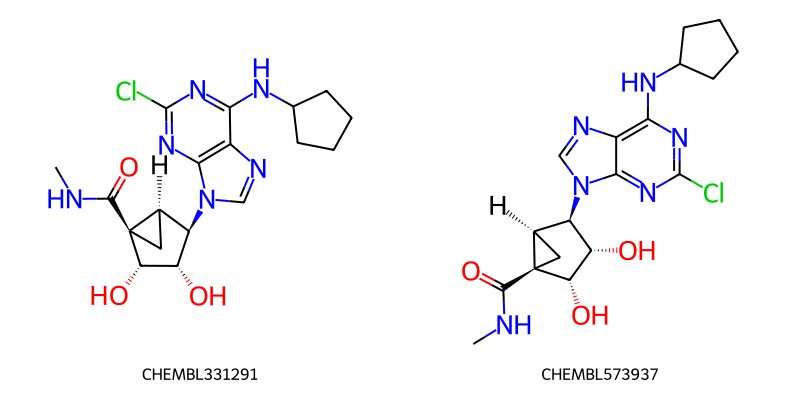

In [414]:
Draw.MolsToGridImage(
    duplicates_df['mol'].to_list(),
    legends=duplicates_df['molecule_chembl_id'].to_list(),
    molsPerRow=2,
    subImgSize=(400, 400)
)

In [415]:
desc = dm.descriptors.batch_compute_many_descriptors(duplicates_df['mol'].to_list())

In [416]:
duplicates_df = pd.concat([duplicates_df, desc], axis=1)
duplicates_df

,molecule_chembl_id,mol,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,n_heavy_atoms,n_rotatable_bonds,n_radical_electrons,tpsa,qed,clogp,sas,n_aliphatic_carbocycles,n_aliphatic_heterocyles,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings
0,CHEMBL331291,<rdkit.Chem.rdchem.Mol object at 0x000001C542E...,406.152016,0.666667,9,4,5,10,28,4,0,125.19,0.554752,0.863,4.278042,3,0,3,0,2,2,3,0,3
1,CHEMBL573937,<rdkit.Chem.rdchem.Mol object at 0x000001C542E...,406.152016,0.666667,9,4,5,10,28,4,0,125.19,0.554752,0.863,4.278042,3,0,3,0,2,2,3,0,3


Calcuated descriptors are the same, so it looks like these to compounds are equivalent.

In [417]:
duplicates_df['maccs'] = duplicates_df['mol'].apply(MACCSkeys.GenMACCSKeys)

In [418]:
DataStructs.TanimotoSimilarity(duplicates_df['maccs'][0], duplicates_df['maccs'][1])

1.0

So, Tanimoto based on MACCS keys says that they are the same

In [419]:
rd_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
duplicates_df['rd_fingerprints'] = duplicates_df['mol'].apply(rd_gen.GetFingerprint)
DataStructs.TanimotoSimilarity(duplicates_df['rd_fingerprints'][0], duplicates_df['rd_fingerprints'][1])

1.0

And Tanimoto based on rdkit fingerprint generator says that are the same

Everything says that those two molecules are equivalent, but I will keep them becaus there may be some steric problems because of the structure.

Last saved data frame is data_1

In [420]:
data_1.head()

,molecule_chembl_id,Ki,units,pKi,smiles
0,CHEMBL132806,57.0,nM,7.24,CC(C)CCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4...
1,CHEMBL336217,42.0,nM,7.38,CC(C)CCn1cc2c(nc(NC(=O)Cc3cccc4ccccc34)n3nc(-c...
2,CHEMBL134566,60.0,nM,7.22,O=C(Cc1ccccc1)Nc1nc2nn(CCCc3ccccc3)cc2c2nc(-c3...
3,CHEMBL435022,38.0,nM,7.42,CC(C)CCn1cc2c(nc(NC(=O)COc3ccccc3)n3nc(-c4ccco...
4,CHEMBL341376,423.0,nM,6.37,Cn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4)nc23)n1


In [421]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  4177 non-null   object 
 1   Ki                  4177 non-null   float64
 2   units               4177 non-null   object 
 3   pKi                 4177 non-null   float64
 4   smiles              4177 non-null   object 
dtypes: float64(2), object(3)
memory usage: 163.3+ KB


Lipinski!

We need to find molecules that have no more than one violation of Lipinski's rule of 5. First, we have to add mol column to the df

In [422]:
PandasTools.AddMoleculeColumnToFrame(data_1, smilesCol='smiles')

Using datamol, we will calculate descriptors

In [423]:
desc_dict = {
    'molecular_weight': dm.descriptors.mw,
    'n_hba': dm.descriptors.n_lipinski_hba,
    'n_hbd': dm.descriptors.n_lipinski_hbd,
    'logp': dm.descriptors.clogp
}

In [424]:
desc = dm.descriptors.batch_compute_many_descriptors(mols=data_1['ROMol'], properties_fn=desc_dict, add_properties=False)
desc

,molecular_weight,n_hba,n_hbd,logp
0,429.191323,9,1,3.96130
1,479.206973,9,1,5.11450
2,477.191323,9,1,4.54800
3,445.186238,10,1,3.79760
4,373.128723,9,1,2.45220
...,...,...,...,...
4172,465.212452,11,4,3.25492
4173,465.212452,11,6,3.13370
4174,479.228102,11,6,3.44212
4175,358.075202,4,1,5.35310


Let's those values assign to a new data frame data_2

In [425]:
data_2 = pd.concat([data_1, desc], axis=1)
data_2.head()

,molecule_chembl_id,Ki,units,pKi,smiles,ROMol,molecular_weight,n_hba,n_hbd,logp
0,CHEMBL132806,57.0,nM,7.24,CC(C)CCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4...,<rdkit.Chem.rdchem.Mol object at 0x000001C542A...,429.191323,9,1,3.9613
1,CHEMBL336217,42.0,nM,7.38,CC(C)CCn1cc2c(nc(NC(=O)Cc3cccc4ccccc34)n3nc(-c...,<rdkit.Chem.rdchem.Mol object at 0x000001C542A...,479.206973,9,1,5.1145
2,CHEMBL134566,60.0,nM,7.22,O=C(Cc1ccccc1)Nc1nc2nn(CCCc3ccccc3)cc2c2nc(-c3...,<rdkit.Chem.rdchem.Mol object at 0x000001C542A...,477.191323,9,1,4.5480
3,CHEMBL435022,38.0,nM,7.42,CC(C)CCn1cc2c(nc(NC(=O)COc3ccccc3)n3nc(-c4ccco...,<rdkit.Chem.rdchem.Mol object at 0x000001C542A...,445.186238,10,1,3.7976
4,CHEMBL341376,423.0,nM,6.37,Cn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4)nc23)n1,<rdkit.Chem.rdchem.Mol object at 0x000001C542A...,373.128723,9,1,2.4522


In [426]:
passed = []
for _, row in data_2.iterrows():
    passed.append(sum([row['molecular_weight'] <= 500, row['n_hba'] <= 10, row['n_hbd'] <= 5, row['logp'] <= 5]) >= 3)
data_2['passed'] = passed

Lets check it on random samples

In [427]:
data_2[data_2['passed']].sample(5)

,molecule_chembl_id,Ki,units,pKi,smiles,ROMol,molecular_weight,n_hba,n_hbd,logp,passed
121,CHEMBL100832,28900.00,nM,4.54,CCCn1c(=O)c2nn(-c3ccc(Cl)cc3N)nc2n(CCC)c1=O,<rdkit.Chem.rdchem.Mol object at 0x000001C542A...,362.125802,8,2,1.7995,True
2373,CHEMBL1935768,119.00,nM,6.92,Cn1ncc2nc(NC3CCCCC3)n3nc(-c4ccco4)nc3c21,<rdkit.Chem.rdchem.Mol object at 0x000001C542A...,337.165108,8,1,3.0156,True
1535,CHEMBL522434,6870.00,nM,5.16,COc1ccc(O)c(CNc2nc(Cl)nc3c2ncn3[C@H]2[C@H](O)[...,<rdkit.Chem.rdchem.Mol object at 0x000001C542A...,417.120382,9,4,1.7186,True
3036,CHEMBL3763717,0.30,nM,9.52,Nc1nc(C(=O)NCc2cccc3cccnc23)c2ccc(F)cc2n1,<rdkit.Chem.rdchem.Mol object at 0x000001C542A...,347.118238,6,3,2.8293,True
181,CHEMBL273094,7.89,nM,8.10,CCCn1c(=O)c2[nH]c(-c3ccc(OCC(=O)NCCN)cc3)nc2n(...,<rdkit.Chem.rdchem.Mol object at 0x000001C542A...,428.217203,10,4,0.8270,True


In [428]:
data_2[~data_2['passed']].sample(5)

,molecule_chembl_id,Ki,units,pKi,smiles,ROMol,molecular_weight,n_hba,n_hbd,logp,passed
426,CHEMBL329712,380.0,nM,6.42,Nc1nc(-n2cc(C(=O)NC3CCCC3)cn2)nc2c1ncn2[C@@H]1...,<rdkit.Chem.rdchem.Mol object at 0x000001C542A...,444.186966,13,6,-1.1219,False
223,CHEMBL36786,2000.0,nM,5.70,Nc1nc(NC(=O)CCC2CCCC2)nc2c1ncn2[C@@H]1O[C@H](C...,<rdkit.Chem.rdchem.Mol object at 0x000001C542A...,406.196468,11,6,-0.0711,False
1810,CHEMBL583745,766.0,nM,6.12,CNC(=O)[C@]12C[C@@H]1[C@@H](n1cnc3c(NCc4cccc(C...,<rdkit.Chem.rdchem.Mol object at 0x000001C542A...,594.246979,12,7,1.1074,False
2391,CHEMBL1950654,84.3,nM,7.07,CCNC(=O)[C@H]1O[C@@H](n2cnc3c(N)nc(NCCc4ccc(CC...,<rdkit.Chem.rdchem.Mol object at 0x000001C542A...,660.301996,15,7,0.6515,False
256,CHEMBL36734,10800.0,nM,4.97,CCNC(=O)[C@H]1O[C@@H](n2cnc3c(N)nc(NC(=O)CCC4C...,<rdkit.Chem.rdchem.Mol object at 0x000001C542A...,447.223017,12,6,0.0727,False


We will keep those molecules without more than 1 violations of Lipinski's rule of 5

In [429]:
data_2 = data_2[data_2['passed']]

In [430]:
data_2.reset_index(drop=True, inplace=True)

In [431]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3715 entries, 0 to 3714
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  3715 non-null   object 
 1   Ki                  3715 non-null   float64
 2   units               3715 non-null   object 
 3   pKi                 3715 non-null   float64
 4   smiles              3715 non-null   object 
 5   ROMol               3715 non-null   object 
 6   molecular_weight    3715 non-null   float64
 7   n_hba               3715 non-null   int64  
 8   n_hbd               3715 non-null   int64  
 9   logp                3715 non-null   float64
 10  passed              3715 non-null   bool   
dtypes: bool(1), float64(4), int64(2), object(4)
memory usage: 294.0+ KB


In [432]:
data_1.shape, data_2.shape

((4177, 6), (3715, 11))

Before saving, we have to del 'ROMol' column

In [433]:
data_2.drop(columns='ROMol', inplace=True)

In [434]:
data_2.to_csv('data_lipinski.csv')

some statistics for molecules that obey Lipinki's rule

In [478]:
stats_lipinski = data_2.describe().T[['mean', 'std']][2:]
stats_lipinski

,mean,std
molecular_weight,372.043628,73.780657
n_hba,7.455989,2.237726
n_hbd,2.059758,1.278707
logp,2.699818,1.407023


PAINS and Problems

Let's remove PAINS using catalog

In [435]:
pains_params = FilterCatalogParams()
pains_params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
pains_cat = FilterCatalog(pains_params)

we have to add mol column again

In [440]:
PandasTools.AddMoleculeColumnToFrame(data_2, smilesCol='smiles', molCol='mol')

In [442]:
data_2.shape

(3715, 11)

In [449]:
pains_matches = []
clean_indices = []
for index, row in data_2.iterrows():
    match = pains_cat.GetFirstMatch(row['mol'])
    if match:
        pains_matches.append({
            'chembl_id': row['molecule_chembl_id'],
            'mol': row['mol'],
            'description': match.GetDescription()
        })
    else:
        clean_indices.append(index)


pains_matches = pd.DataFrame(pains_matches)
data_3 = data_2.iloc[clean_indices]

Sorted PAINS

In [450]:
pains_matches.groupby('description').size().sort_values(ascending=False)

description
anil_di_alk_C(246)     44
catechol_A(92)         13
anil_no_alk(40)         9
quinone_A(370)          8
azo_A(324)              6
hzone_phenol_A(479)     6
anil_di_alk_E(186)      4
anthranil_one_A(38)     3
mannich_A(296)          3
anil_di_alk_A(478)      2
anil_di_alk_B(251)      1
dyes5A(27)              1
dtype: int64

In [455]:
data_3.reset_index(drop=True, inplace=True)

In [452]:
data_3.shape, pains_matches.shape

((3615, 11), (100, 3))

We have excluded 100 PAINS

Benks citeria

In [453]:
brenk_params = FilterCatalogParams()
brenk_params.AddCatalog(FilterCatalogParams.FilterCatalogs.BRENK)
brenk_cat = FilterCatalog(brenk_params)

In [469]:
brenk_matches = []
clean_indices = []
num_brenks = 0
for index, row in data_3.iterrows():
    matches = brenk_cat.GetMatches(row['mol'])
    if matches:
        for match in matches:
            brenk_matches.append({
                'chembl_id': row['molecule_chembl_id'],
                'mol': row['mol'],
                'description': match.GetDescription()
            })
        num_brenks += 1
    else:
        clean_indices.append(index)
brenk_matches = pd.DataFrame(brenk_matches)
data_4 = data_3.iloc[clean_indices].copy()

In [470]:
len(data_4), num_brenks

(2943, 672)

Let's check everything again

In [471]:
len(data_4) + num_brenks == len(data_3)

True

We excluded 672 molecules using Brenk's catalog. Reasons are:

In [472]:
brenk_matches.groupby(by='description').size().sort_values(ascending=False)

description
Aliphatic_long_chain                 200
triple_bond                          153
Oxygen-nitrogen_single_bond          150
iodine                                58
aniline                               55
hydroxamic_acid                       52
nitro_group                           39
alkyl_halide                          30
imine_1                               29
Thiocarbonyl_group                    27
heavy_metal                           17
cumarine                              17
isolated_alkene                       15
imine_2                               15
Michael_acceptor_1                    12
Sulfonic_acid_2                       10
2-halo_pyridine                        9
phenol_ester                           8
thiol_2                                6
phthalimide                            6
hydrazine                              5
N-hydroxyl_pyridine                    4
quaternary_nitrogen_1                  4
N_oxide                                4
disu

We can see that most molecules are excluded upon multiple criteria

Reset index, drop mol column and save df

In [473]:
data_4.reset_index(drop=True, inplace=True)
data_4.drop(columns=['mol'], inplace=True)
data_4.to_csv('data_clean.csv')

In [474]:
data_4.head()

,molecule_chembl_id,Ki,units,pKi,smiles,molecular_weight,n_hba,n_hbd,logp,passed
0,CHEMBL132806,57.0,nM,7.24,CC(C)CCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4...,429.191323,9,1,3.9613,True
1,CHEMBL336217,42.0,nM,7.38,CC(C)CCn1cc2c(nc(NC(=O)Cc3cccc4ccccc34)n3nc(-c...,479.206973,9,1,5.1145,True
2,CHEMBL134566,60.0,nM,7.22,O=C(Cc1ccccc1)Nc1nc2nn(CCCc3ccccc3)cc2c2nc(-c3...,477.191323,9,1,4.5480,True
3,CHEMBL435022,38.0,nM,7.42,CC(C)CCn1cc2c(nc(NC(=O)COc3ccccc3)n3nc(-c4ccco...,445.186238,10,1,3.7976,True
4,CHEMBL341376,423.0,nM,6.37,Cn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4)nc23)n1,373.128723,9,1,2.4522,True


In [475]:
data_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2943 entries, 0 to 2942
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  2943 non-null   object 
 1   Ki                  2943 non-null   float64
 2   units               2943 non-null   object 
 3   pKi                 2943 non-null   float64
 4   smiles              2943 non-null   object 
 5   molecular_weight    2943 non-null   float64
 6   n_hba               2943 non-null   int64  
 7   n_hbd               2943 non-null   int64  
 8   logp                2943 non-null   float64
 9   passed              2943 non-null   bool   
dtypes: bool(1), float64(4), int64(2), object(3)
memory usage: 209.9+ KB


Let's look for the statistics for cleaned df and after elininating Lipinski rule of 5 violators

In [506]:
stats_clean = data_4.describe().T[['mean', 'std']][2:].add_prefix('cleaned ')
stats_clean

,cleaned mean,cleaned std
molecular_weight,364.945495,71.299803
n_hba,7.247367,2.114011
n_hbd,1.886510,1.127810
logp,2.812499,1.336937


In [508]:
stats_lipinski = stats_lipinski.add_prefix('lipinski ')

In [509]:
stats = pd.concat([stats_lipinski, stats_clean], axis=1, names=['Lipinski', 'Cleaned'])
stats

,lipinski mean,lipinski std,cleaned mean,cleaned std
molecular_weight,372.043628,73.780657,364.945495,71.299803
n_hba,7.455989,2.237726,7.247367,2.114011
n_hbd,2.059758,1.278707,1.886510,1.127810
logp,2.699818,1.407023,2.812499,1.336937


Clustering

In [510]:
data_4.head()

,molecule_chembl_id,Ki,units,pKi,smiles,molecular_weight,n_hba,n_hbd,logp,passed
0,CHEMBL132806,57.0,nM,7.24,CC(C)CCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4...,429.191323,9,1,3.9613,True
1,CHEMBL336217,42.0,nM,7.38,CC(C)CCn1cc2c(nc(NC(=O)Cc3cccc4ccccc34)n3nc(-c...,479.206973,9,1,5.1145,True
2,CHEMBL134566,60.0,nM,7.22,O=C(Cc1ccccc1)Nc1nc2nn(CCCc3ccccc3)cc2c2nc(-c3...,477.191323,9,1,4.5480,True
3,CHEMBL435022,38.0,nM,7.42,CC(C)CCn1cc2c(nc(NC(=O)COc3ccccc3)n3nc(-c4ccco...,445.186238,10,1,3.7976,True
4,CHEMBL341376,423.0,nM,6.37,Cn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4)nc23)n1,373.128723,9,1,2.4522,True


In [511]:
data_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2943 entries, 0 to 2942
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  2943 non-null   object 
 1   Ki                  2943 non-null   float64
 2   units               2943 non-null   object 
 3   pKi                 2943 non-null   float64
 4   smiles              2943 non-null   object 
 5   molecular_weight    2943 non-null   float64
 6   n_hba               2943 non-null   int64  
 7   n_hbd               2943 non-null   int64  
 8   logp                2943 non-null   float64
 9   passed              2943 non-null   bool   
dtypes: bool(1), float64(4), int64(2), object(3)
memory usage: 209.9+ KB


MACCS Keys

In [512]:
maccs = [MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(sm)) for sm in data_4['smiles'].to_list()]

Function that returns distances calculated on Tanimoto similarities

In [513]:
def get_distances(fingerprints):
    distances = []
    for i in range(1, len(fingerprints)):
        similarity = DataStructs.BulkTanimotoSimilarity(fingerprints[i], fingerprints[:i])
        distances.extend([1 - sim for sim in similarity])
    return distances

Function that returns cluster numbers molecules belong to

In [514]:
def get_clusters(fingerprints, cut_off):
    distances = get_distances(fingerprints)
    clusters = Butina.ClusterData(distances, len(fingerprints), cut_off, isDistData=True)
    # clusters must be sorted by its sizes in descending order
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

Function for plotting clusters size distribution for various cut_off values

In [522]:
def plot_clustes(fingerprints):
    br = 0
    fig, ax = plt.subplots(10, 1, figsize=(10, 20))
    for cut_off in np.arange(0.0, 1.0, 0.1):
        cls = get_clusters(fingerprints, cut_off=cut_off)
        ax[br].bar(x=np.arange(1, len(cls) + 1), height=[len(c) for c in cls])
        ax[br].set_title(f'{len(cls)} clusters, cut_off = {cut_off:.2f}')
        ax[br].set_xlabel('Clusters')
        ax[br].set_ylabel('Cluster Sizes')
        ax[br].grid()
        br += 1
    plt.tight_layout()


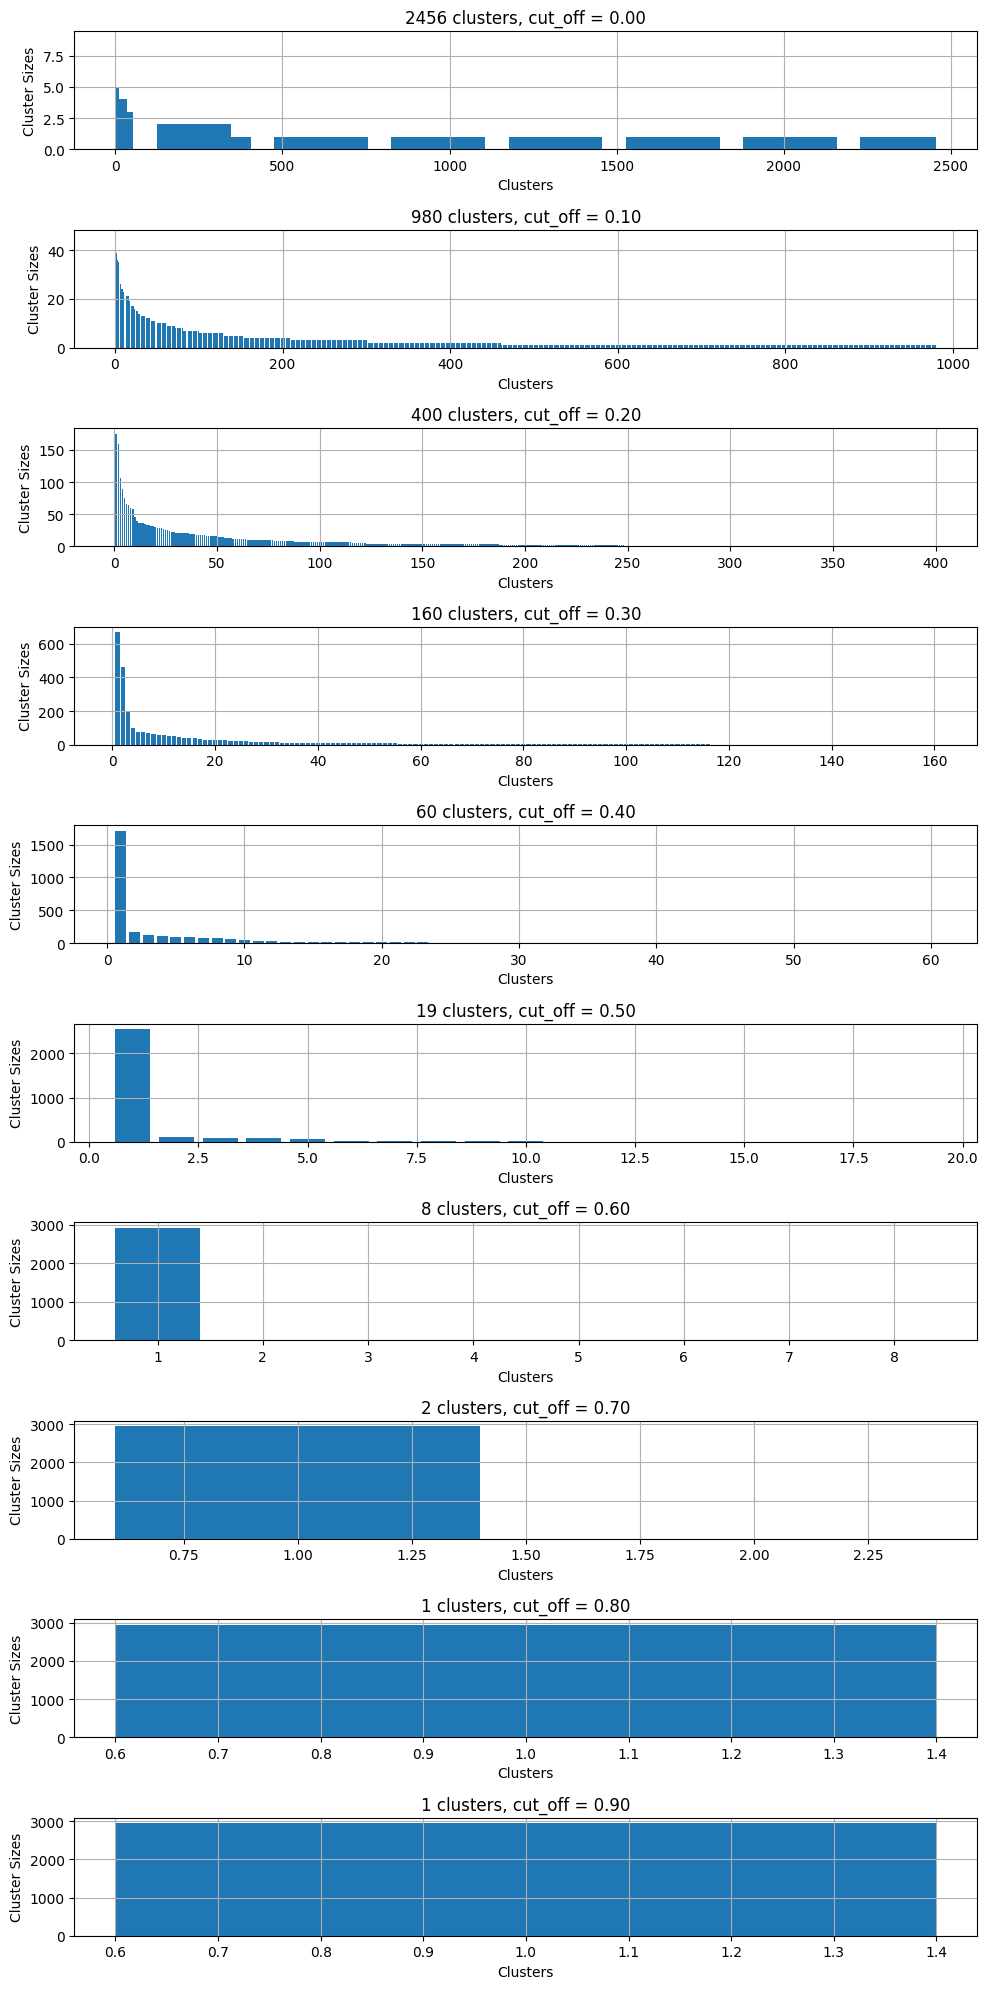

In [523]:
plot_clustes(maccs)

cut_off value of 0.2 looks reasonable to me

In [524]:
clusters_maccs = get_clusters(maccs, 0.2)

Let's add function that returns list of cluster numbers

In [525]:
def get_cluster_list(clusters, length):
    cls_list = [-1] * length
    for i in range(len(clusters)):
        for cluster_number in clusters[i]:
            cls_list[cluster_number] = i
    return cls_list

In [528]:
data_4['maccs_clusters'] = get_cluster_list(clusters_maccs, len(data_4))

In [530]:
data_4.head(10)

,molecule_chembl_id,Ki,units,pKi,smiles,molecular_weight,n_hba,n_hbd,logp,passed,maccs_clusters
0,CHEMBL132806,57.00,nM,7.24,CC(C)CCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4...,429.191323,9,1,3.9613,True,0
1,CHEMBL336217,42.00,nM,7.38,CC(C)CCn1cc2c(nc(NC(=O)Cc3cccc4ccccc34)n3nc(-c...,479.206973,9,1,5.1145,True,0
2,CHEMBL134566,60.00,nM,7.22,O=C(Cc1ccccc1)Nc1nc2nn(CCCc3ccccc3)cc2c2nc(-c3...,477.191323,9,1,4.5480,True,0
3,CHEMBL435022,38.00,nM,7.42,CC(C)CCn1cc2c(nc(NC(=O)COc3ccccc3)n3nc(-c4ccco...,445.186238,10,1,3.7976,True,21
4,CHEMBL341376,423.00,nM,6.37,Cn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4)nc23)n1,373.128723,9,1,2.4522,True,0
5,CHEMBL138593,45.00,nM,7.35,O=C(COc1ccccc1)Nc1nc2nn(CCCc3ccccc3)cc2c2nc(-c...,493.186238,10,1,4.3843,True,36
6,CHEMBL324735,381.00,nM,6.42,Cn1cc2c(nc(NC(=O)Nc3ccccc3)n3nc(-c4ccco4)nc23)n1,374.123972,10,2,2.9150,True,0
7,CHEMBL16867,0.31,nM,9.51,Nc1nc2nn(CCc3ccccc3)cc2c2nc(-c3ccco3)nn12,345.133808,8,2,2.5589,True,0
8,CHEMBL541455,60.00,nM,7.22,O=C(Cc1ccccc1)Nc1nc2nn(CCc3ccccc3)cc2c2nc(-c3c...,463.175673,9,1,4.1579,True,0
9,CHEMBL16687,1.70,nM,8.77,Nc1nc2ccc(Cl)cc2c2nc(-c3ccco3)nn12,285.041738,6,2,2.7731,True,61


First let's add mol column again

In [531]:
PandasTools.AddMoleculeColumnToFrame(data_4, smilesCol='smiles', molCol='mol')

First ten molecules from first cluster

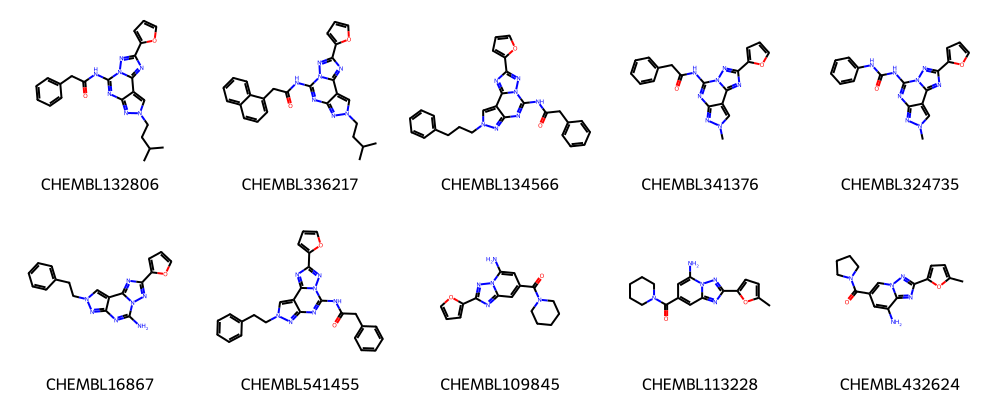

In [534]:
Draw.MolsToGridImage(
    data_4['mol'][data_4['maccs_clusters'] == 0][:10].to_list(),
    legends=data_4['molecule_chembl_id'][data_4['maccs_clusters'] == 0][:10].to_list(),
    molsPerRow=5
)

First ten molecules from second cluster

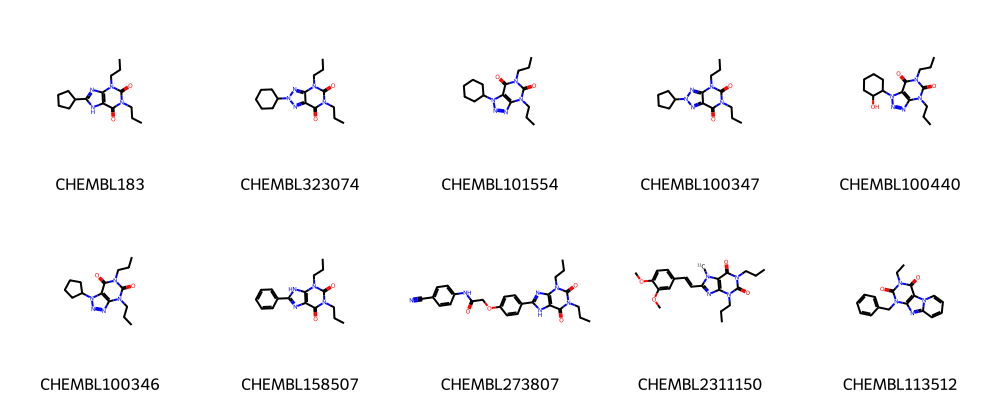

In [535]:
Draw.MolsToGridImage(
    data_4['mol'][data_4['maccs_clusters'] == 1][:10].to_list(),
    legends=data_4['molecule_chembl_id'][data_4['maccs_clusters'] == 1][:10].to_list(),
    molsPerRow=5
)

First ten molecules from third cluster

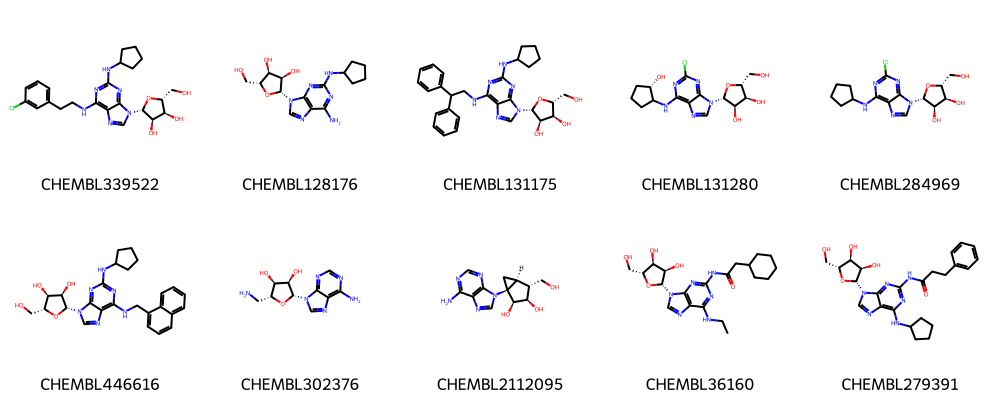

In [536]:
Draw.MolsToGridImage(
    data_4['mol'][data_4['maccs_clusters'] == 2][:10].to_list(),
    legends=data_4['molecule_chembl_id'][data_4['maccs_clusters'] == 2][:10].to_list(),
    molsPerRow=5
    )

First molecules from first ten clusters

In [557]:
firsts = data_4.drop_duplicates('maccs_clusters', keep='first').sort_values(by='maccs_clusters')[:10]
firsts

,molecule_chembl_id,Ki,units,pKi,smiles,molecular_weight,n_hba,n_hbd,logp,passed,maccs_clusters,mol
0,CHEMBL132806,57.00,nM,7.24,CC(C)CCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4...,429.191323,9,1,3.96130,True,0,<rdkit.Chem.rdchem.Mol object at 0x000001C5541...
57,CHEMBL183,200.00,nM,6.70,CCCn1c(=O)c2[nH]c(C3CCCC3)nc2n(CCC)c1=O,304.189926,6,1,2.36390,True,1,<rdkit.Chem.rdchem.Mol object at 0x000001C5541...
92,CHEMBL339522,39.00,nM,7.41,OC[C@H]1O[C@@H](n2cnc3c(NCCc4cccc(Cl)c4)nc(NC4...,488.193881,10,5,2.10030,True,2,<rdkit.Chem.rdchem.Mol object at 0x000001C5541...
106,CHEMBL16416,376.00,nM,6.42,COc1ccc(-n2nc3c(N)nc4ccccc4n3c2=O)cc1,307.106925,7,2,1.62420,True,3,<rdkit.Chem.rdchem.Mol object at 0x000001C5541...
634,CHEMBL252171,2.00,nM,8.70,Cc1cc(C)n(-c2cc(NC(=O)CN3CCN(C)CC3)nc(-c3ccco3...,395.206973,9,1,1.72504,True,4,<rdkit.Chem.rdchem.Mol object at 0x000001C55A3...
271,CHEMBL342059,2.80,nM,8.55,Cn1cc2c(nc(N)n3nc(-c4ccco4)nc23)n1,255.086858,8,2,0.85320,True,5,<rdkit.Chem.rdchem.Mol object at 0x000001C5541...
1278,CHEMBL538629,7.60,nM,8.12,Nc1nc(C(=O)NCc2ccccc2)cc(-c2ccco2)n1,294.111676,6,3,2.24880,True,6,<rdkit.Chem.rdchem.Mol object at 0x000001C547F...
107,CHEMBL273094,7.89,nM,8.10,CCCn1c(=O)c2[nH]c(-c3ccc(OCC(=O)NCCN)cc3)nc2n(...,428.217203,10,4,0.82700,True,7,<rdkit.Chem.rdchem.Mol object at 0x000001C5541...
882,CHEMBL260721,45.00,nM,7.35,COC(=O)c1cccc(Cn2cnc3c(-c4ccco4)nc(N)nc32)c1,349.117489,8,2,2.50340,True,8,<rdkit.Chem.rdchem.Mol object at 0x000001C55A3...
542,CHEMBL376920,118.00,nM,6.93,Cc1ccc(-c2cc(-c3ccccc3)nc(N)c2C#N)cc1,285.126597,3,2,4.17790,True,9,<rdkit.Chem.rdchem.Mol object at 0x000001C55A3...


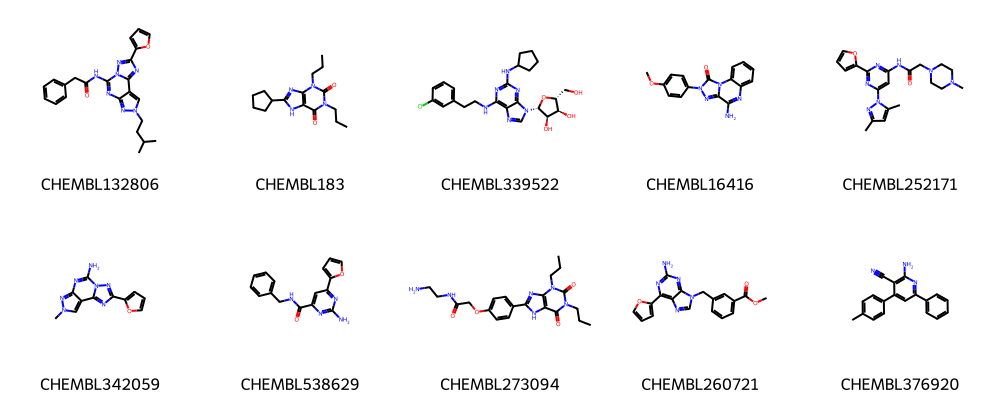

In [560]:
Draw.MolsToGridImage(
    firsts['mol'].to_list(),
    legends=[f"firsts['molecule_chembl_id'].to_list()"],
    molsPerRow=5
)

ECFP4 fingerprints

In [563]:
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2)
morgans = data_4['mol'].apply(morgan_gen.GetFingerprint)

In [564]:
len(morgans), len(morgans[0])

(2943, 2048)

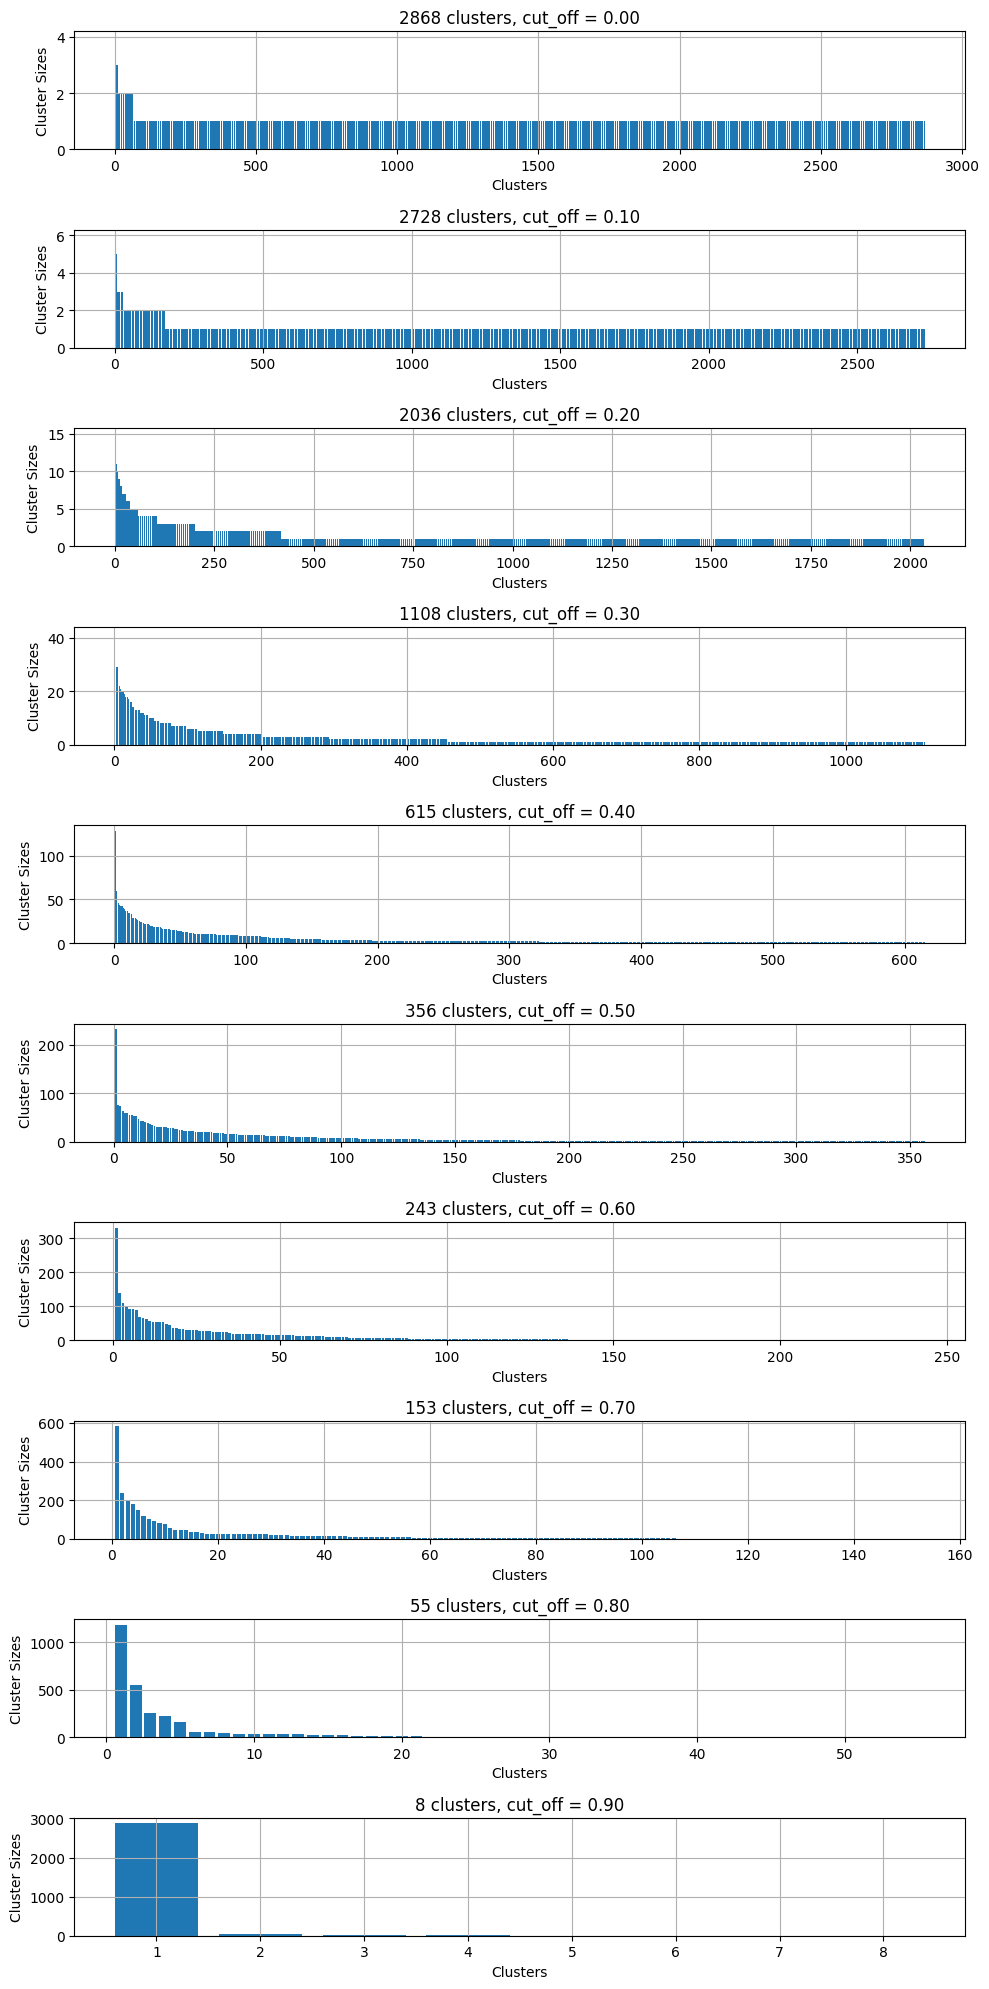

In [566]:
plot_clustes(morgans)

cut_off value of 0.4 looks reasonable to me

In [567]:
morgan_clusters = get_clusters(morgans, cut_off=0.4)

In [568]:
data_4['ECFP4_clusters'] = get_cluster_list(morgan_clusters, len(data_4))

In [570]:
data_4.head()

,molecule_chembl_id,Ki,units,pKi,smiles,molecular_weight,n_hba,n_hbd,logp,passed,maccs_clusters,mol,ECFP4_clusters
0,CHEMBL132806,57.0,nM,7.24,CC(C)CCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4...,429.191323,9,1,3.9613,True,0,<rdkit.Chem.rdchem.Mol object at 0x000001C5541...,3
1,CHEMBL336217,42.0,nM,7.38,CC(C)CCn1cc2c(nc(NC(=O)Cc3cccc4ccccc34)n3nc(-c...,479.206973,9,1,5.1145,True,0,<rdkit.Chem.rdchem.Mol object at 0x000001C5541...,3
2,CHEMBL134566,60.0,nM,7.22,O=C(Cc1ccccc1)Nc1nc2nn(CCCc3ccccc3)cc2c2nc(-c3...,477.191323,9,1,4.5480,True,0,<rdkit.Chem.rdchem.Mol object at 0x000001C5541...,3
3,CHEMBL435022,38.0,nM,7.42,CC(C)CCn1cc2c(nc(NC(=O)COc3ccccc3)n3nc(-c4ccco...,445.186238,10,1,3.7976,True,21,<rdkit.Chem.rdchem.Mol object at 0x000001C5541...,3
4,CHEMBL341376,423.0,nM,6.37,Cn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4)nc23)n1,373.128723,9,1,2.4522,True,0,<rdkit.Chem.rdchem.Mol object at 0x000001C5541...,0


First cluster

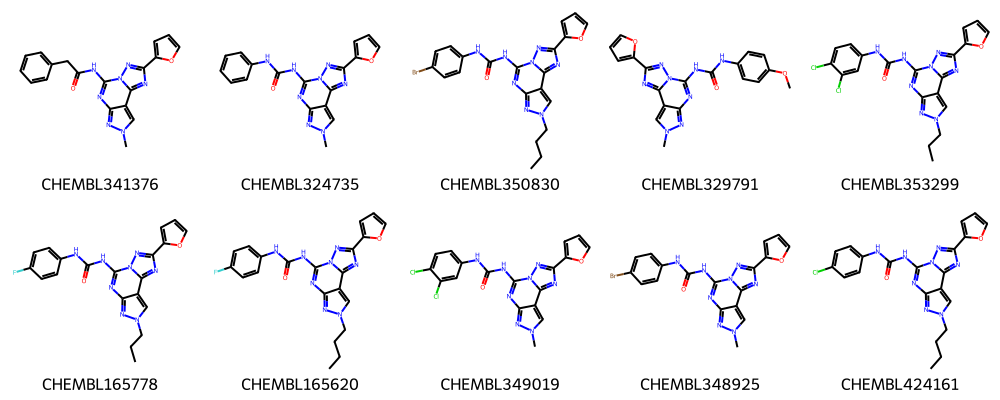

In [573]:
Draw.MolsToGridImage(
    data_4['mol'][data_4['ECFP4_clusters'] == 0][:10].to_list(),
    legends=data_4['molecule_chembl_id'][data_4['ECFP4_clusters'] == 0][:10].to_list(),
    molsPerRow=5
)

Second clusters

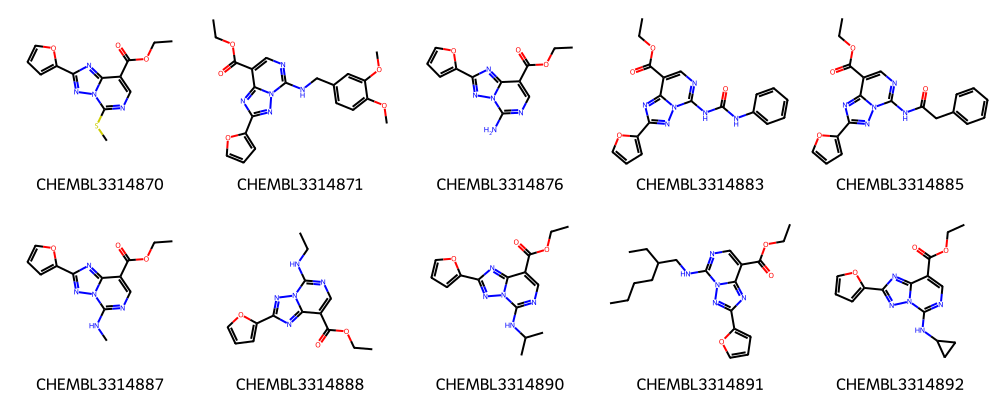

In [574]:
Draw.MolsToGridImage(
    data_4['mol'][data_4['ECFP4_clusters'] == 1][:10].to_list(),
    legends=data_4['molecule_chembl_id'][data_4['ECFP4_clusters'] == 1][:10].to_list(),
    molsPerRow=5
)

Third

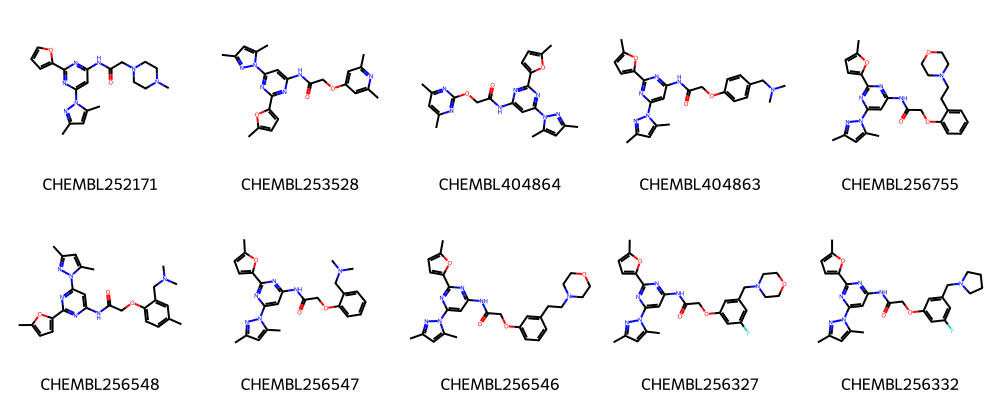

In [575]:
Draw.MolsToGridImage(
    data_4['mol'][data_4['ECFP4_clusters'] == 2][:10].to_list(),
    legends=data_4['molecule_chembl_id'][data_4['ECFP4_clusters'] == 2][:10].to_list(),
    molsPerRow=5
)

In [580]:
firsts_morgan = data_4.drop_duplicates(subset='ECFP4_clusters', keep='first').sort_values(by='ECFP4_clusters')[:10]
firsts_morgan

,molecule_chembl_id,Ki,units,pKi,smiles,molecular_weight,n_hba,n_hbd,logp,passed,maccs_clusters,mol,ECFP4_clusters
4,CHEMBL341376,423.00,nM,6.37,Cn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4)nc23)n1,373.128723,9,1,2.45220,True,0,<rdkit.Chem.rdchem.Mol object at 0x000001C5541...,0
2015,CHEMBL3314870,9500.00,nM,5.02,CCOC(=O)c1cnc(SC)n2nc(-c3ccco3)nc12,304.063011,7,0,2.28290,True,8,<rdkit.Chem.rdchem.Mol object at 0x000001C547F...,1
634,CHEMBL252171,2.00,nM,8.70,Cc1cc(C)n(-c2cc(NC(=O)CN3CCN(C)CC3)nc(-c3ccco3...,395.206973,9,1,1.72504,True,4,<rdkit.Chem.rdchem.Mol object at 0x000001C55A3...,2
0,CHEMBL132806,57.00,nM,7.24,CC(C)CCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4...,429.191323,9,1,3.96130,True,0,<rdkit.Chem.rdchem.Mol object at 0x000001C5541...,3
1278,CHEMBL538629,7.60,nM,8.12,Nc1nc(C(=O)NCc2ccccc2)cc(-c2ccco2)n1,294.111676,6,3,2.24880,True,6,<rdkit.Chem.rdchem.Mol object at 0x000001C547F...,4
7,CHEMBL16867,0.31,nM,9.51,Nc1nc2nn(CCc3ccccc3)cc2c2nc(-c3ccco3)nn12,345.133808,8,2,2.55890,True,0,<rdkit.Chem.rdchem.Mol object at 0x000001C5541...,5
2443,CHEMBL4079325,7.40,nM,8.13,CC(C)Oc1ccc(-c2cn3c(=O)n(-c4ccccc4)nc3c(N)n2)cc1,361.153875,7,2,2.91660,True,3,<rdkit.Chem.rdchem.Mol object at 0x000001C548A...,6
2221,CHEMBL3765818,1.10,nM,8.96,Nc1nc(C(=O)NCc2cccc3cccnc23)c2ccccc2n1,329.127660,6,3,2.69020,True,18,<rdkit.Chem.rdchem.Mol object at 0x000001C547F...,7
1360,CHEMBL594363,1.00,nM,9.00,Cc1ccc(-c2cc(C(=O)NCc3ncc[nH]3)nc(N)n2)o1,298.117824,8,4,1.28032,True,6,<rdkit.Chem.rdchem.Mol object at 0x000001C547F...,8
429,CHEMBL200780,1500.00,nM,5.82,CCCn1c(=O)c2nc(-c3cnn(CC(=O)Nc4ccccc4Cl)c3)[nH...,469.162915,10,2,2.86190,True,1,<rdkit.Chem.rdchem.Mol object at 0x000001C55A3...,9


First molecules from first 10 clusters

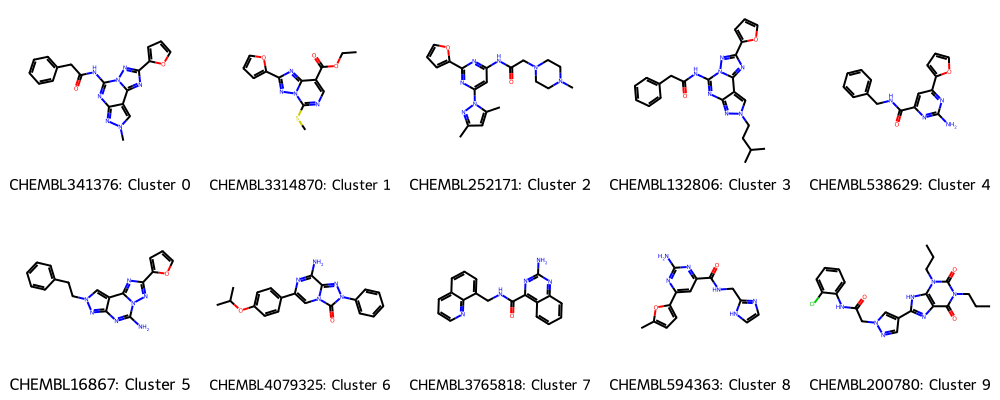

In [581]:
Draw.MolsToGridImage(
    firsts_morgan['mol'].to_list(),
    legends=[f"{row['molecule_chembl_id']}: Cluster {row['ECFP4_clusters']}" for _, row in firsts_morgan.iterrows()],
    molsPerRow=5
)